# Importing

In [510]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import os

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

from pylab import rcParams
rcParams.update({'font.size' : 14, 'legend.fontsize' : "small", 
                 "xtick.labelsize" : 14, "ytick.labelsize" : 14, 
                 "figure.figsize":(9, 6), "axes.titlesize" : 20,
                 "axes.labelsize" : 14, "lines.linewidth" : 3, 
                 "lines.markersize" : 10
                })

In [511]:
train = pd.read_csv("titanic3.csv")

# Summarizing data

Significant number of values missing, I could leave this up to the algorithm like boosted trees to deal with or try to find to a reasonable measure to impute with. It is not clear what would lead to better results.

In [512]:
train.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [513]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


In [514]:
train.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [515]:
# body is an id assigned to bodies found
train.drop('body', axis = 1, inplace = True)

In [516]:
train.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON"


# Feature engineering

In [517]:
# function for extracting letters or numbers

def find_info(entry, number = True ):
        
        if entry is np.nan:
            return np.nan
        else:
            
            entry = re.split('(\d+)', entry)
            numbers = []

            if number is True: 
                for item in entry: 
                    if item.isnumeric():
                        numbers.append(int(item))
                    else:
                        pass
                return np.mean(numbers)

            else: 
                for item in entry: 
                    if item[0].isalpha():
                        return item
                

In [518]:
cabin_number = train['cabin'].apply(find_info, number = True)
cabin_letter = train['cabin'].apply(find_info, number = False)
train['cabin_letter'] = cabin_letter


/home/ryeyoo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [519]:
def encode_column(column, fillna = False):
    
    le = LabelEncoder()
    
    # le does not work with nan
    column = column.fillna('unknown')
    le.fit(column)
    column_le = le.transform(column)
    
    if fillna == False:
        # replace unknown with nan
        column_le = column_le.astype('float')
        idx = [i for i, value in enumerate(column) if column[i]=='unknown']
        column_le[idx] = np.nan

    zip_obj = zip(list(column), column_le)
    return column_le, dict(zip_obj)        


In [520]:
train['cabin_letter_le'] = encode_column(cabin_letter, fillna = True)[0]
train['cabin_number'] = cabin_number
train['home_dest_le'] = encode_column(train['home.dest'], fillna = True)[0]
train['embarked_le'] = encode_column(train['embarked'], fillna = True)[0]
print(encode_column(train['sex'], fillna = True)[1])
train['sex'] = encode_column(train['sex'], fillna = True)[0]

{'female': 0, 'male': 1}


In [521]:
train['embarked_le'].value_counts(dropna=False)

2    914
0    270
1    123
3      2
Name: embarked_le, dtype: int64

In [522]:
train['family'] = train['sibsp'] + train['parch']

In [523]:
train.isnull().sum()

pclass                0
survived              0
name                  0
sex                   0
age                 263
sibsp                 0
parch                 0
ticket                0
fare                  1
cabin              1014
embarked              2
boat                823
home.dest           564
cabin_letter       1014
cabin_letter_le       0
cabin_number       1020
home_dest_le          0
embarked_le           0
family                0
dtype: int64

# Charts

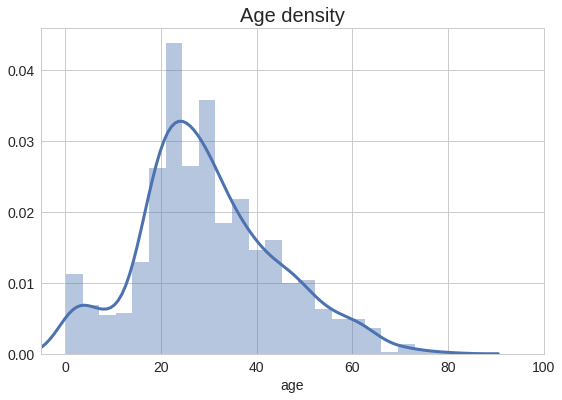

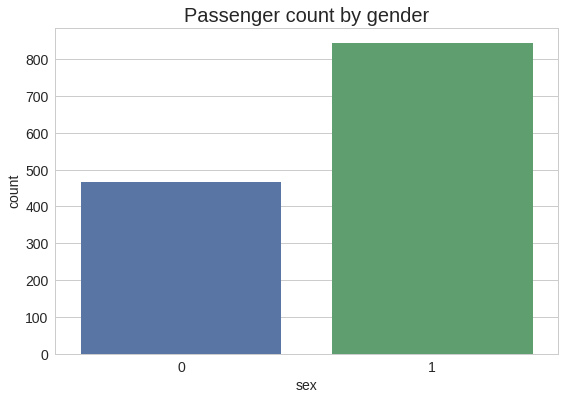

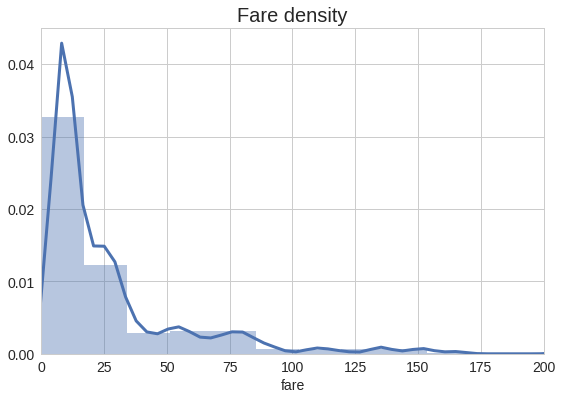

In [524]:
sns.set_style("whitegrid")

plt.title("Age density")
sns.distplot(train['age'].dropna())
plt.xlim(-5,100)
plt.show()

#fig=plt.figure(figsize=(8, 5), dpi = 150, facecolor='w', edgecolor='k')
plt.title("Passenger count by gender")
sns.countplot('sex', data = train)
plt.show()

plt.title("Fare density")
sns.distplot(train['fare'].dropna(), bins = 30)
plt.xlim(0, 200)
plt.show()

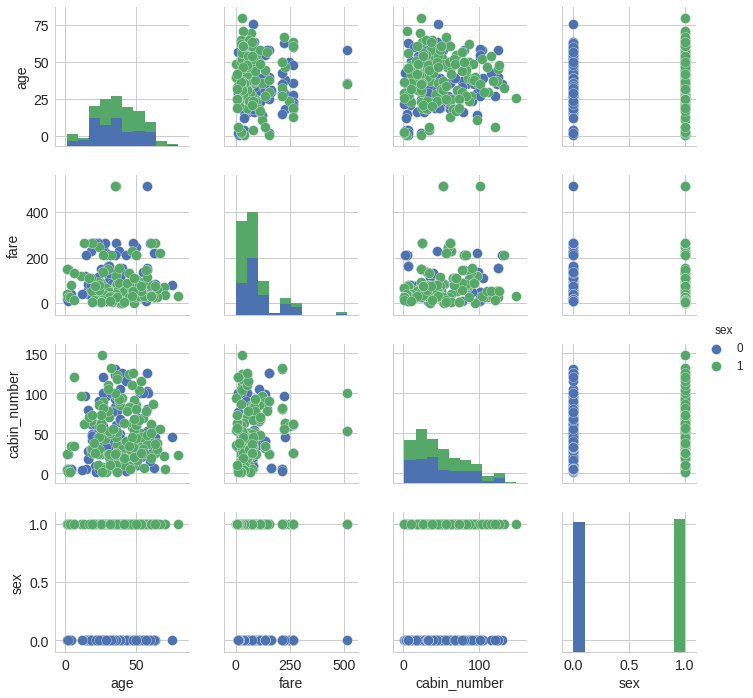

In [525]:
fig=plt.figure(figsize=(16, 16), dpi= 300)
sns.pairplot(data = train[['age', 'fare', 'cabin_number', 'sex']].dropna(), hue = 'sex')
plt.show()

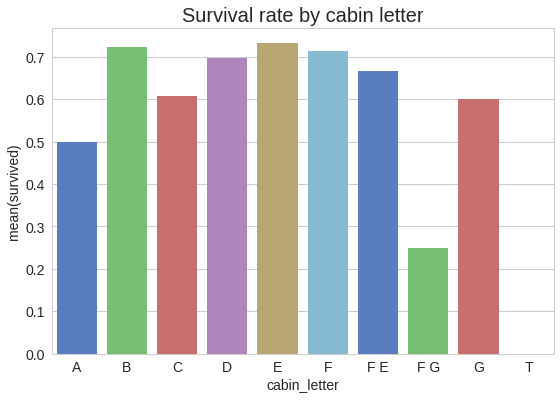

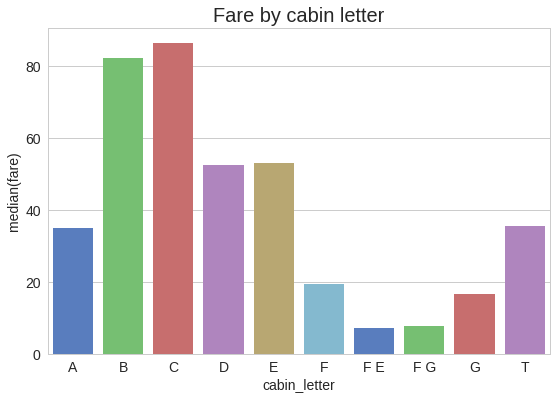

In [526]:
sns.barplot(x = "cabin_letter", y = "survived", data=train.sort_values('cabin_letter'), 
            palette = "muted", ci = None)
plt.title("Survival rate by cabin letter")
plt.show()

sns.barplot(x = "cabin_letter", y = "fare", 
            data=train[train['cabin_letter'].notnull()].sort_values('cabin_letter'), 
            palette = "muted", ci = None, estimator = np.median)
plt.title("Fare by cabin letter")
plt.show()


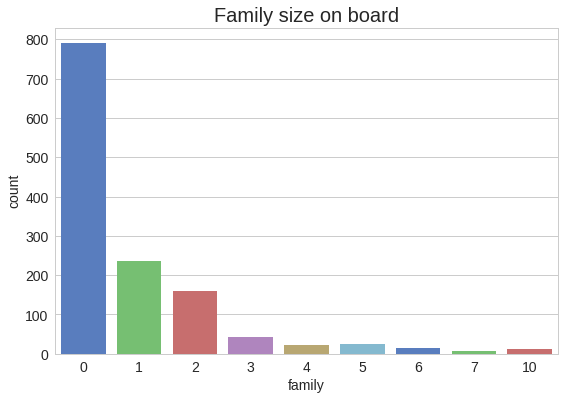

In [527]:
#fig=plt.figure(figsize=(8, 5), dpi = 150, facecolor='w', edgecolor='k')
plt.title("Family size on board")
sns.countplot(train['family'].dropna(), palette='muted')
plt.show()

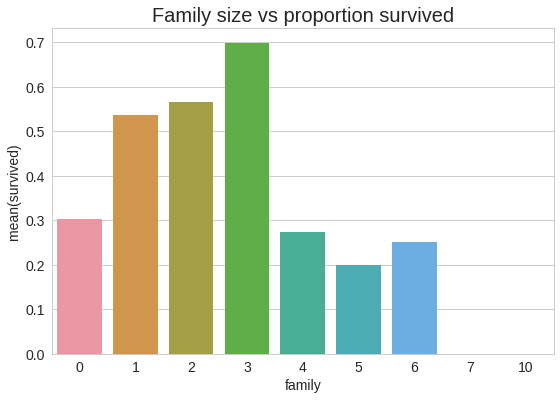

In [528]:
sns.barplot(x = "family", y = "survived", 
            data=train, 
            ci = None)
plt.title("Family size vs proportion survived")
plt.show()

## Missing data

Earlier it was evident that there were columns with a numer of values missing, it is worth considering if missing values have an impact on surviving. 

In [529]:
print(train[train['home.dest'].notnull()]['survived'].mean())
train[train['home.dest'].isnull()]['survived'].mean()

0.4657718120805369


0.2712765957446808

In [530]:
print(train['survived'][train.age.notnull()].mean())
train['survived'][train.age.isnull()].mean()

0.40822179732313574


0.27756653992395436

In [531]:
print(train[train.cabin.notnull()]['survived'].mean())
train[train.cabin.isnull()]['survived'].mean()

0.6542372881355932


0.3027613412228797

In [532]:
train[['home.dest', 'survived', 'fare']].fillna(0).groupby('home.dest').agg(
    ['mean', 'count']).sort_values([('survived', 'count')], ascending=False)[0:20]

survived              fare      
                                               mean count        mean count
home.dest                                                                  
0                                          0.271277   564   20.785668   564
New York, NY                               0.625000    64   62.976041    64
London                                     0.357143    14   20.296429    14
Montreal, PQ                               0.400000    10  117.043740    10
Cornwall / Akron, OH                       0.888889     9   20.305556     9
Paris, France                              0.888889     9   61.556011     9
Winnipeg, MB                               0.500000     8  221.448438     8
Wiltshire, England Niagara Falls, NY       0.000000     8   46.900000     8
Philadelphia, PA                           0.375000     8   28.779687     8
Brooklyn, NY                               0.714286     7   34.200014     7
Belfast                                    0.000000     7    0.000000     7
Sweden Winnipeg, MN                        0.000000     7   31.275000     7
Somerset / Bernardsville, NJ               0.600000     5   65.000000     5
Haverford, PA / Cooperstown, NY            0.800000     5  262.375000     5
Bulgaria Chicago, IL                       0.000000     5    7.815800     5
Rotherfield, Sussex, England Essex Co, MA  0.000000     5   34.375000     5
Ottawa, ON                                 0.200000     5   10.118320     5
Sweden Worcester, MA                       0.400000     5   26.669160     5
Devon, England Wichita, KS                 0.750000     4   20.575000     4
Paris / Montreal, PQ                       0.500000     4   31.514600     4

## Significance testing

In [533]:
table = np.array(pd.crosstab(train['home.dest'].isnull()*1, train['survived']))
print("p-value of chi2 independence test: {}: ".format(chi2_contingency(table, correction=True)[1]))

p-value of chi2 independence test: 1.1231092381458419e-12: 


In [534]:
table = np.array(pd.crosstab(train['age'].isnull()*1, train['survived']))
print("p-value of chi2 independence test: {}: ".format(chi2_contingency(table, correction=True)[1]))

p-value of chi2 independence test: 0.00012952163336165393: 


In [535]:
table = np.array(pd.crosstab(train['cabin'].isnull()*1, train['survived']))
print("p-value of chi2 independence test: {}: ".format(chi2_contingency(table, correction=True)[1]))

p-value of chi2 independence test: 1.649000705015759e-27: 


In [536]:
train['home_dest_null'] = train['home.dest'].isnull()*1
log_model = smf.glm('survived ~ C(home_dest_null)', 
        data = train, family = sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               survived   No. Observations:                 1309
Model:                            GLM   Df Residuals:                     1307
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -844.32
Date:                Tue, 26 Sep 2017   Deviance:                       1688.6
Time:                        19:53:02   Pearson chi2:                 1.31e+03
No. Iterations:                     4                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.1371      0.073     -1.867      0.062      -0.281       0.007
C(home_dest_null)[T.1]    -0.8510      0.120     -7.101      0.000      -1.086      -0.616
==========================================================================================
"""

Looking at the means of missing data from the columns above, it seems like there is a significant difference between survival rates and if data is missing for a particular iv. Checking with logistic regression p-values and the chisq-test do suggest that have null values do indicate

# Preparing data

In [537]:
display(pd.pivot_table(train, index = ["embarked"]))
display(pd.pivot_table(train, index = ["sex"]))

,age,cabin_letter_le,cabin_number,embarked_le,family,fare,home_dest_le,home_dest_null,parch,pclass,sex,sibsp,survived
embarked,,,,,,,,,,,,,
C,32.332170,6.503704,52.584783,0.0,0.770370,62.336267,271.396296,0.362963,0.370370,1.851852,0.581481,0.400000,0.555556
Q,28.630000,9.715447,74.600000,1.0,0.455285,12.409012,299.105691,0.699187,0.113821,2.894309,0.512195,0.341463,0.357724
S,29.245205,8.650985,47.467066,2.0,0.977024,27.418824,266.617068,0.414661,0.426696,2.347921,0.681619,0.550328,0.332604


,age,cabin_letter_le,cabin_number,embarked_le,family,fare,home_dest_le,home_dest_null,parch,pclass,sibsp,survived
sex,,,,,,,,,,,,
0,28.687088,7.733906,48.631295,1.390558,1.285408,46.198097,265.096567,0.381974,0.633047,2.154506,0.652361,0.727468
1,30.585228,8.607355,50.956667,1.552788,0.661922,26.154601,273.608541,0.457888,0.247924,2.372479,0.413998,0.190985


In [538]:
dummy_vars = pd.get_dummies(train['pclass'], prefix = "class")
print(dummy_vars[0:6])

   class_1  class_2  class_3
0        1        0        0
1        1        0        0
2        1        0        0
3        1        0        0
4        1        0        0
5        1        0        0


In [539]:
train_processed = train.join(dummy_vars) 

Could use pclass over encoded class as different columns, under tree-based algorithms this actually works better.

In [540]:
train_processed = train_processed[train_processed.fare.notnull()]
train_processed['sex'] = train_processed['sex'].astype('int')
#train_processed['embarked'] = train_processed['embarked'].astype('int')
feature_columns_to_use =  ['age', 'family', 'pclass', 'embarked_le','sex', 'fare', 'cabin_letter_le', 'cabin_number', 'home_dest_le']


In [541]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308 entries, 0 to 1308
Data columns (total 23 columns):
pclass             1308 non-null int64
survived           1308 non-null int64
name               1308 non-null object
sex                1308 non-null int64
age                1045 non-null float64
sibsp              1308 non-null int64
parch              1308 non-null int64
ticket             1308 non-null object
fare               1308 non-null float64
cabin              295 non-null object
embarked           1306 non-null object
boat               486 non-null object
home.dest          745 non-null object
cabin_letter       295 non-null object
cabin_letter_le    1308 non-null int64
cabin_number       289 non-null float64
home_dest_le       1308 non-null int64
embarked_le        1308 non-null int64
family             1308 non-null int64
home_dest_null     1308 non-null int64
class_1            1308 non-null uint8
class_2            1308 non-null uint8
class_3            1308 non

## splitting train and test for cv

In [542]:
train_x, test_x, train_y, test_y = train_test_split(train_processed[feature_columns_to_use], 
                                                    train_processed['survived'], test_size = .3, random_state = 42)

In [543]:
print(train_x.shape)
print(test_x.shape)

(915, 9)
(393, 9)


## Imputation

From before it was established that there are significant differences between survival rates for columns with missing data, indicating that data is not missing completely at random. Since the missing data is not the cause of survival, it can be reasonably argued that the null values are missing at random and imputation could be valuable. Fancyimpute provides the MICE function to do this for continuous variables ONLY, which threw me off being used to the R version. For this matrix it's imputing the age nan values.

In [544]:
from fancyimpute import MICE

train_x_filled = MICE().complete(train_x.as_matrix())
test_x_filled = MICE().complete(test_x.as_matrix())

[MICE] Completing matrix with shape (915, 9)
[MICE] Starting imputation round 1/110, elapsed time 0.001
[MICE] Starting imputation round 2/110, elapsed time 0.004
[MICE] Starting imputation round 3/110, elapsed time 0.006
[MICE] Starting imputation round 4/110, elapsed time 0.007
[MICE] Starting imputation round 5/110, elapsed time 0.008
[MICE] Starting imputation round 6/110, elapsed time 0.009
[MICE] Starting imputation round 7/110, elapsed time 0.009
[MICE] Starting imputation round 8/110, elapsed time 0.010
[MICE] Starting imputation round 9/110, elapsed time 0.011
[MICE] Starting imputation round 10/110, elapsed time 0.012
[MICE] Starting imputation round 11/110, elapsed time 0.013
[MICE] Starting imputation round 12/110, elapsed time 0.013
[MICE] Starting imputation round 13/110, elapsed time 0.014
[MICE] Starting imputation round 14/110, elapsed time 0.015
[MICE] Starting imputation round 15/110, elapsed time 0.016
[MICE] Starting imputation round 16/110, elapsed time 0.016
[MIC

[MICE] Starting imputation round 87/110, elapsed time 0.065
[MICE] Starting imputation round 88/110, elapsed time 0.065
[MICE] Starting imputation round 89/110, elapsed time 0.066
[MICE] Starting imputation round 90/110, elapsed time 0.068
[MICE] Starting imputation round 91/110, elapsed time 0.068
[MICE] Starting imputation round 92/110, elapsed time 0.069
[MICE] Starting imputation round 93/110, elapsed time 0.070
[MICE] Starting imputation round 94/110, elapsed time 0.071
[MICE] Starting imputation round 95/110, elapsed time 0.071
[MICE] Starting imputation round 96/110, elapsed time 0.072
[MICE] Starting imputation round 97/110, elapsed time 0.073
[MICE] Starting imputation round 98/110, elapsed time 0.074
[MICE] Starting imputation round 99/110, elapsed time 0.074
[MICE] Starting imputation round 100/110, elapsed time 0.075
[MICE] Starting imputation round 101/110, elapsed time 0.076
[MICE] Starting imputation round 102/110, elapsed time 0.078
[MICE] Starting imputation round 103/

# Models

## logistic

In [545]:
model = LogisticRegression()
model = model.fit(X = train_x_filled, y = train_y)
print(model.score(X = train_x_filled, y = train_y))

0.805464480874


# random forest

In [546]:
rf_model = RandomForestClassifier(n_estimators = 500, random_state=42).fit(train_x_filled, train_y)
rf_model.score(train_x_filled, train_y)

1.0

# support vector machines

In [547]:
svm_m = SVC(gamma=0.01, C=1, probability = True).fit(train_x_filled, train_y)
svm_m.score(train_x_filled, train_y)

0.87650273224043718

## xgboost (gradient boosted trees)

In [548]:
model_xgb = XGBClassifier(
  learning_rate =0.01,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=5,
 gamma=0.00,
 subsample=0.9,
 colsample_bytree=0.8,
 reg_alpha=0.05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

cvresult = xgb.cv(
                  model_xgb.get_xgb_params(), 
                  xgb.DMatrix(train_x_filled, label=train['survived'].values), 
                  num_boost_round=model_xgb.get_params()['n_estimators'], 
                  nfold=3, metrics=['auc','logloss'], 
                  early_stopping_rounds=50
                 )

#model_xgb.set_params(n_estimators=cvresult.shape[0])
    
# fit the algorithm 

model_xgb.fit(train_x_filled, train_y, eval_metric='logloss')

xgb_result1 = model_xgb.fit(train_x_filled, train_y)
xgb_result1.score(train_x_filled, train_y)

0.92459016393442628

In [549]:
cvresult.iloc[-1,:]

test-auc-mean         0.543468
test-auc-std          0.012426
test-logloss-mean     0.685718
test-logloss-std      0.000931
train-auc-mean        0.843433
train-auc-std         0.000360
train-logloss-mean    0.633156
train-logloss-std     0.001067
Name: 67, dtype: float64

## Tuning xgb

In [550]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['auc','logloss'], early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # fit the algorithm 
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='logloss')
        
    # predict training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    # print model report
    print("\nModel Report")
    print("Accuracy : {:.4f}".format(accuracy_score(dtrain[target].values, dtrain_predictions)))
    print("AUC Score (Train): {:.4f}".format(roc_auc_score(dtrain[target], dtrain_predprob)))
    print("logloss :{:.4f}".format(log_loss(dtrain[target], dtrain_predprob)))
    
    # plotting feat_imp
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    return feat_imp


Model Report
Accuracy : 0.8792
AUC Score (Train): 0.9472
logloss :0.3081


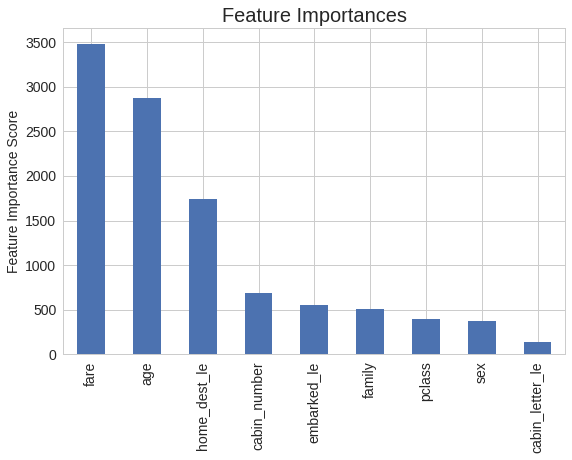

In [551]:
model_xgb1 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=5,
 gamma=0.00,
 subsample=0.9,
 colsample_bytree=0.8,
 reg_alpha=0.05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

top_features = modelfit(model_xgb1, train_processed, feature_columns_to_use, target = 'survived')[:-1]


Model Report
Accuracy : 0.8761
AUC Score (Train): 0.9461
logloss :0.3105


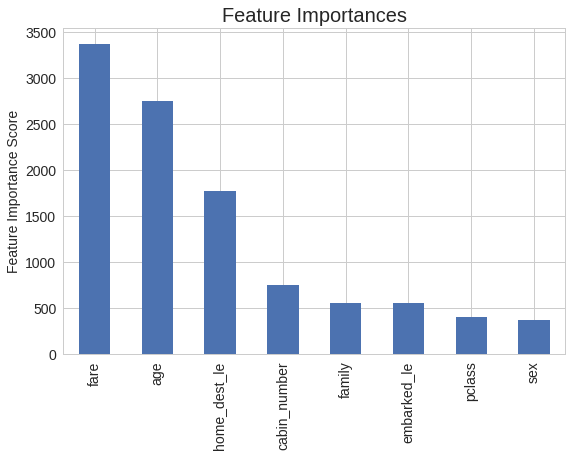

fare            3373
age             2748
home_dest_le    1774
cabin_number     752
family           555
embarked_le      552
pclass           405
sex              376
dtype: int64

In [552]:
model_xgb1 = XGBClassifier(learning_rate =0.01, n_estimators=1000,
                             max_depth=9, min_child_weight=5,
                             gamma=0.00, subsample=0.9,
                             colsample_bytree=0.8, reg_alpha=0.05,
                             objective= 'binary:logistic', nthread=4,
                             scale_pos_weight=1, seed=27)

modelfit(model_xgb1, train_processed, top_features.index, 
         target = 'survived')

# Evaluation

## logistic

In [553]:

predicted = model.predict(test_x_filled)
predicted_prob = model.predict_proba(test_x_filled)

#print(metrics.confusion_matrix(train_y, predicted))
#print(train_y.astype(float).mean())
#print(predicted.astype(int).mean())

print("auc: " + str(roc_auc_score(test_y, predicted)))
print("log loss: {}".format(log_loss(test_y, predicted_prob)))
print(classification_report(test_y, predicted))

auc: 0.776553747666
log loss: 0.473998868270317
             precision    recall  f1-score   support

          0       0.79      0.88      0.83       230
          1       0.80      0.67      0.73       163

avg / total       0.79      0.79      0.79       393



## random forest

In [554]:
predicted_rf = rf_model.predict(test_x_filled)
predicted_rf_prob = rf_model.predict_proba(test_x_filled)
print("auc:" + str(roc_auc_score(test_y, predicted_rf)))
print("log loss: {}".format(log_loss(test_y, predicted_rf_prob)))
print(classification_report(test_y, predicted_rf))

auc:0.769138436917
log loss: 0.4425430370398979
             precision    recall  f1-score   support

          0       0.79      0.87      0.83       230
          1       0.78      0.67      0.72       163

avg / total       0.79      0.79      0.78       393



## svm

In [555]:
predicted_svm = svm_m.predict(test_x_filled)
predicted_svm_prob = svm_m.predict_proba(test_x_filled)
print("auc:" + str(roc_auc_score(test_y, predicted_svm)))
print("log loss: {}".format(log_loss(test_y, predicted_svm_prob)))
print(classification_report(test_y, predicted_svm))

auc:0.577167244599
log loss: 0.6323940885288083
             precision    recall  f1-score   support

          0       0.63      0.88      0.73       230
          1       0.62      0.28      0.38       163

avg / total       0.63      0.63      0.59       393



## xgb

In [556]:
# with MICE impute
predicted_xgb = model_xgb.predict(test_x_filled)
predicted_xgb_proba = model_xgb.predict_proba(test_x_filled)
print("auc:" + str(roc_auc_score(test_y, predicted_xgb)))
print("log loss: {}".format(log_loss(test_y, predicted_xgb_proba)))
print(classification_report(test_y, predicted_xgb))

auc:0.769911976527
log loss: 0.44728168211261204
             precision    recall  f1-score   support

          0       0.78      0.90      0.83       230
          1       0.81      0.64      0.72       163

avg / total       0.79      0.79      0.79       393



In [557]:
# standard xgb impute
predicted_xgb = model_xgb1.predict(test_x[top_features.index])
predicted_xgb_proba = model_xgb1.predict_proba(test_x[top_features.index])
print("auc:" + str(roc_auc_score(test_y, predicted_xgb)))
print("log loss: {}".format(log_loss(test_y, predicted_xgb_proba)))
print(classification_report(test_y, predicted_xgb))

auc:0.851720458789
log loss: 0.3072043496537148
             precision    recall  f1-score   support

          0       0.85      0.93      0.89       230
          1       0.89      0.77      0.83       163

avg / total       0.87      0.87      0.86       393



Boosted trees with regularization(xgb) seems to be the best performing, while svm and rf had a high accuracy on the training set it looks like they overfit the training data. Logistic performed above expectations, plus it is easily the most interpretable algorithm.

# Digging into logistic models

## statsmodels logistic instead of sklearn

In [558]:
log_model = smf.glm('survived ~ C(pclass) + fare + family + C(sex) + age', 
        data = train.iloc[0:915,], family = sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               survived   No. Observations:                  815
Model:                            GLM   Df Residuals:                      808
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -355.89
Date:                Tue, 26 Sep 2017   Deviance:                       711.78
Time:                        19:53:08   Pearson chi2:                     851.
No. Iterations:                     5                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.1858      0.453      9.233      0.000       3.297       5.074
C(pclass)[T.2]    -1.3864      0.276     -5.032      0.000      -1.926      -0.846
C(pclass)[T.3]    -2.4291      0.319     -7.623      0.000      -3.054      -1.805
C(sex)[T.1]       -3.0037      0.211    -14.233      0.000      -3.417      -2.590
fare               0.0009      0.002      0.477      0.634      -0.003       0.005
family            -0.0789      0.073     -1.081      0.280      -0.222       0.064
age               -0.0416      0.008     -5.448      0.000      -0.057      -0.027
==================================================================================
"""

In [559]:
log_model.params

Intercept         4.185769
C(pclass)[T.2]   -1.386387
C(pclass)[T.3]   -2.429148
C(sex)[T.1]      -3.003683
fare              0.000947
family           -0.078895
age              -0.041629
dtype: float64

## Interpreting results


In [560]:
# men labeled 1

print("ratio for p(survive) women/men "  + str(np.exp(log_model.params[3])))
print("ratio inc/dec for each parent/child " + str(np.exp((log_model.params[5]))))

ratio for p(survive) women/men 0.049604044481
ratio inc/dec for each parent/child 0.924136541186
